The structure of the dataset files that are downloaded looks like this (You will notice that the test directory has no subdirectories and the images are not labeled):

cats_and_dogs

|__ train:

    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:

    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import streamlit as st

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator     

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

from sklearn.metrics import confusion_matrix, classification_report

2023-10-15 09:05:40.694202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
PATH = 'cats_and_dogs/'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
# The test directory have one subdirectory for dogs and cats.
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
# batch_size = 64
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
# Check the total number of the data by train, validation and test
print("TRAIN DATA: ", total_train, "VALIDATION DATA: ", total_val, "TEST DATA: ", total_test)

TRAIN DATA:  2001 VALIDATION DATA:  1001 TEST DATA:  51


In [4]:
# Generate train, validation and test data from the directory
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    class_mode='binary',
)
val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    class_mode='binary',
)
test_data_gen = test_image_generator.flow_from_directory(
    PATH,
    classes = ['test'],
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = 1,
    class_mode=None,
    shuffle=False # to check the predictions with test expectation(test_labels).
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [5]:
# Check the classes
train_data_gen.class_indices

{'cats': 0, 'dogs': 1}

In [6]:
def plotImages(images_arr, probabilities = False):
    """
    Plot image
    Input: 
        images_arr: list of images
        probabilities: list of probabilities
    Output:
        plot image
    """
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
        for img, ax in zip( images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, ax in zip( images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if probability > 0.5:
                ax.set_title("%.2f" % (probability*100) + "% dog")
            else:
                ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()


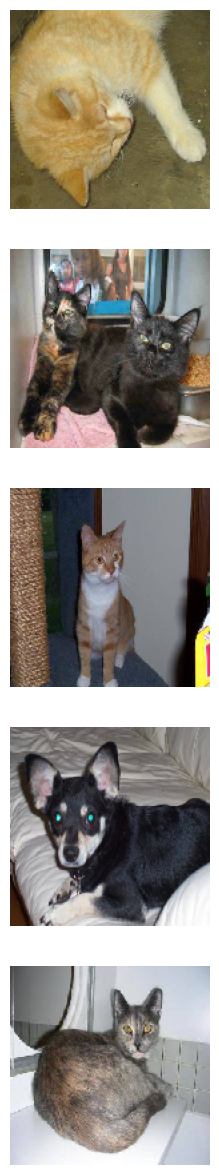

In [7]:
# Check the sample training images
sample_training_images, labels = next(train_data_gen)
plotImages(sample_training_images[:5])

In [8]:
# Random transformations to create more training data
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

Found 2000 images belonging to 2 classes.


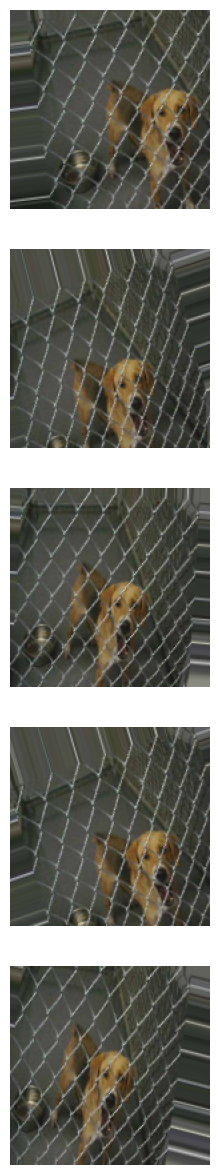

In [9]:
# Generate the train data with random transformations
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

# Plot the images with random transformations
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [10]:
# Create the CNN model 
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

# Check the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

2023-10-15 09:05:49.859671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


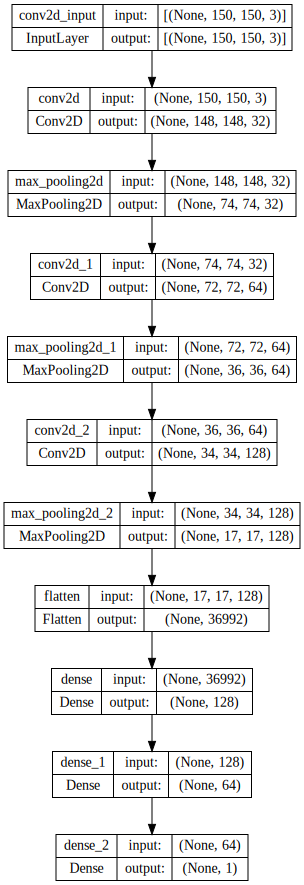

In [11]:
# plot model
SVG(model_to_dot(model, show_shapes=True, expand_nested=False, dpi=72).create(prog='dot', format='svg'))

In [12]:
# Fit the model with training and validation data
history = model.fit(train_data_gen, 
                    epochs=epochs,
                    steps_per_epoch=int(np.ceil(total_train / float(batch_size))), 
                    validation_data=val_data_gen,
                    validation_steps=int(np.ceil(total_val / float(batch_size)))
                    )

Epoch 1/15
16/16 [==============================] - 31s 2s/step - loss: 1.1005 - accuracy: 0.5050 - val_loss: 0.6922 - val_accuracy: 0.5450
Epoch 2/15
16/16 [==============================] - 31s 2s/step - loss: 0.6889 - accuracy: 0.5190 - val_loss: 0.9806 - val_accuracy: 0.5000
Epoch 3/15
16/16 [==============================] - 30s 2s/step - loss: 0.7099 - accuracy: 0.5300 - val_loss: 0.6702 - val_accuracy: 0.5950
Epoch 4/15
16/16 [==============================] - 32s 2s/step - loss: 0.6928 - accuracy: 0.5430 - val_loss: 0.6786 - val_accuracy: 0.5480
Epoch 5/15
16/16 [==============================] - 29s 2s/step - loss: 0.6987 - accuracy: 0.5165 - val_loss: 0.6786 - val_accuracy: 0.5100
Epoch 6/15
16/16 [==============================] - 36s 2s/step - loss: 0.6856 - accuracy: 0.5600 - val_loss: 0.6769 - val_accuracy: 0.5700
Epoch 7/15
16/16 [==============================] - 34s 2s/step - loss: 0.6698 - accuracy: 0.6050 - val_loss: 0.7093 - val_accuracy: 0.5120
Epoch 8/15
16/16 [==

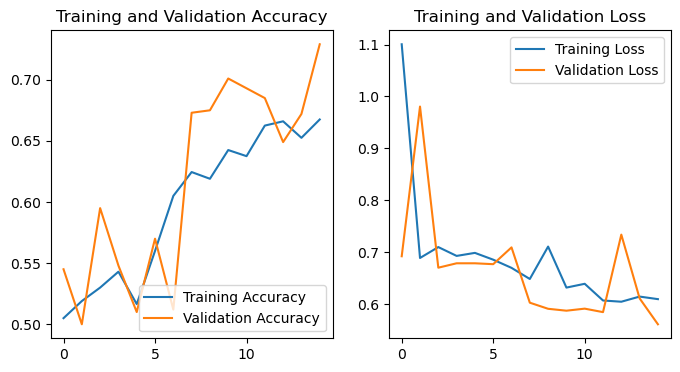

In [13]:
# Check the history of accuracy and loss by epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

50/50 [==============================] - 1s 14ms/step


/var/folders/p4/h9nrqcxj31g_8pbs1l9jm7j80000gn/T/ipykernel_5450/573878269.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
/var/folders/p4/h9nrqcxj31g_8pbs1l9jm7j80000gn/T/ipykernel_5450/573878269.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % (probability*100) + "% dog")


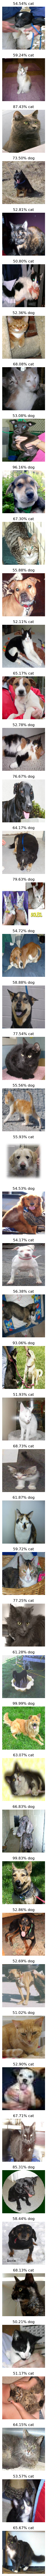

In [14]:
# Check the probailities by images
probabilities = model.predict(test_data_gen)
plotImages([test_data_gen[i][0] for i in range(50)],probabilities=probabilities)

In [15]:
# Check the accuracy with test labels 
test_labels =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, test_labels):
    if round(probability[0]) == answer:
        correct +=1

percentage_identified = (correct / len(test_labels)) * 100

passed_challenge = percentage_identified > 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!


50/50 [==============================] - 1s 13ms/step


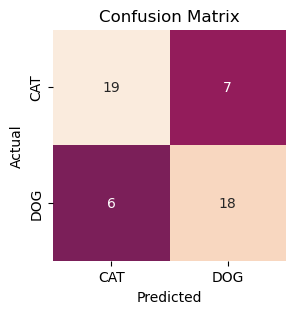

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.76      0.73      0.75        26
         DOG       0.72      0.75      0.73        24

    accuracy                           0.74        50
   macro avg       0.74      0.74      0.74        50
weighted avg       0.74      0.74      0.74        50



In [16]:
# Check the confusion matrix and classification report
predictions = (model.predict(test_data_gen) > 0.5)

cm = confusion_matrix(test_labels, predictions, labels=[0, 1])
clr = classification_report(test_labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)